In [1]:
using Distributions
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png)
using SymPy

function make_ecdf(A)
    _ecdf = ecdf(A)
    f(x) = _ecdf(x)
    f
end

ecdf_naive(A, x) = count(≤(x), A)/length(A)

distname(dist) = replace(string(dist), r"{[^\}]*}"=>"")

function distname(dist::MixtureModel)
    d = distname.(dist.components)
    d = replace.(d, r", σ=1.0"=>"")
    p = string.(dist.prior.p)
    name = "$(p[1]) $(d[1])"
    name *= prod(" + $(p[i]) $(d[i])" for i in 2:length(d))
    name
end

distname (generic function with 2 methods)

$\newcommand\op{\operatorname}$

期待値 $0$, 分散 $1$ の一様分布 $\op{Uniform}(-\sqrt{3}, \sqrt{3})$ のモーメント母函数は

$$
M(t) = \frac{1}{2\sqrt{3}}\int_{-\sqrt{3}}^{\sqrt{3}} e^{tx}\,dx
= \frac{e^{\sqrt{3}\,t} - e^{-\sqrt{3}\,t}}{2\sqrt{3}\,t}
$$

キュムラント母函数 $\log M(t)$ を求めよう.

In [2]:
@vars t
expr = log((exp(√Sym(3)*t) - exp(-√Sym(3)*t))/(2√Sym(3)*t))
Eq(expr, expr.series(t; n=12).simplify())

   /      /   ___         ___  \\                                       
   |  ___ | \/ 3 *t    -\/ 3 *t||    2    4     6      8    10          
   |\/ 3 *\e        - e        /|   t    t     t    3*t    t       / 12\
log|----------------------------| = -- - -- + --- - ---- + ---- + O\t  /
   \            6*t             /   2    20   105   1400   1925         

離散一様分布 $\op{DiscreteUniform}(1, N)$ の期待値と分散とモーメント母函数はそれぞれ

$$
\mu = \frac{N+1}{2}, \quad
\sigma^2 = \frac{N^2-1}{12}, \quad
M(t) = \frac{1}{N}\sum_{k=1}^N e^{tk}
= \frac{e^{(N+1)t} - e^t}{N(e^t - 1)}
= \frac{e^{Nt}-1}{N(1-e^{-t})}.
$$

標準化されたキュムラント母函数

$$
\log M(t/\sigma) - \frac{\mu}{\sigma} t
$$

を $N=6$ の場合について求めよう.

In [3]:
@vars t
N = Sym(6)
μ = (N + 1)/2
σ = √((N^2 - 1)/12)
expr = (exp(N*t) - 1)/(N*(1 - exp(-t)))
expr = log(expr(t => t/σ)) - μ/σ*t
Eq(expr, expr.series(t; n=12).simplify())

                 /       _____        \                                       
                 |  12*\/ 105 *t      |                                       
                 |  ------------      |                                       
    _____        |       35           |    2       4         6           8    
  \/ 105 *t      | e             - 1  |   t    37*t    1333*t    143967*t    3
- --------- + log|--------------------| = -- - ----- + ------- - --------- + -
      5          |            _____   |   2     700     128625    60025000    
                 |       -2*\/ 105 *t |                                       
                 |       -------------|                                       
                 |             35     |                                       
                 \6 - 6*e             /                                       

                 
                 
                 
      10         
1411*t      / 12\
-------- + O\t  /
52521875         
    

In [4]:
function ecdf_samplemean(dist, n; L=10^6)
    X̄ = Vector{Float64}(undef, L)
    Xtmp = [Vector{eltype(dist)}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(dist, Xtmp[tid])
        X̄[i] = mean(X)
    end
    make_ecdf(X̄)
end

ecdf_samplemean (generic function with 1 method)

dist = Uniform() = Uniform{Float64}(a=0.0, b=1.0)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (0.5, 0.28867513459481287)


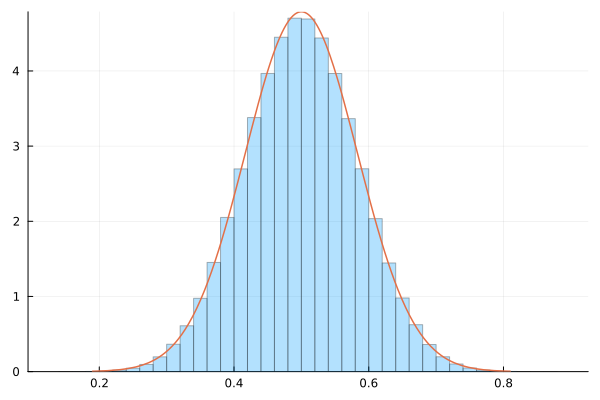

In [5]:
@show dist = Uniform()
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=50, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = Uniform() = Uniform{Float64}(a=0.0, b=1.0)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (0.5, 0.28867513459481287)


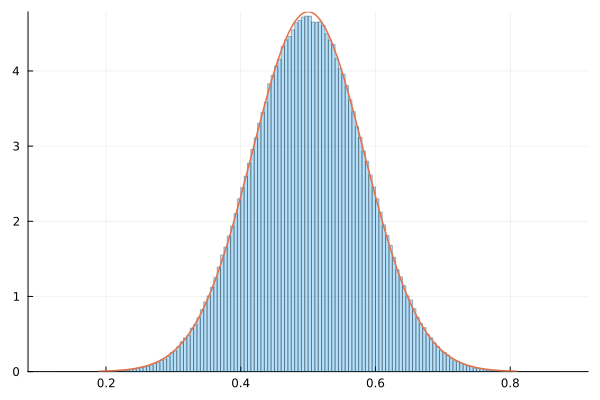

In [6]:
@show dist = Uniform()
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=200, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = DiscreteUniform(1, 6) = DiscreteUniform(a=1, b=6)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (3.5, 1.707825127659933)


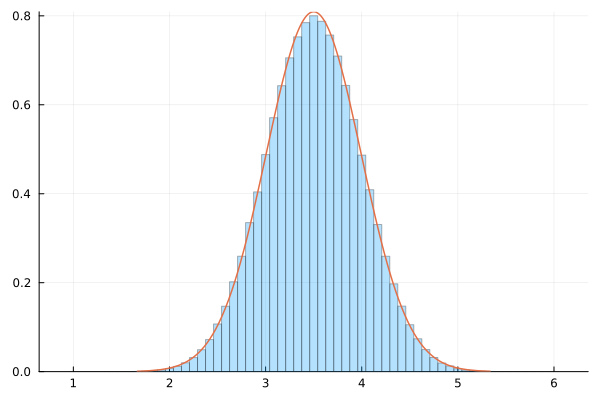

In [7]:
@show dist = DiscreteUniform(1, 6)
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=1-1/24:1/12:6+1/24, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = DiscreteUniform(1, 6) = DiscreteUniform(a=1, b=6)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (3.5, 1.707825127659933)


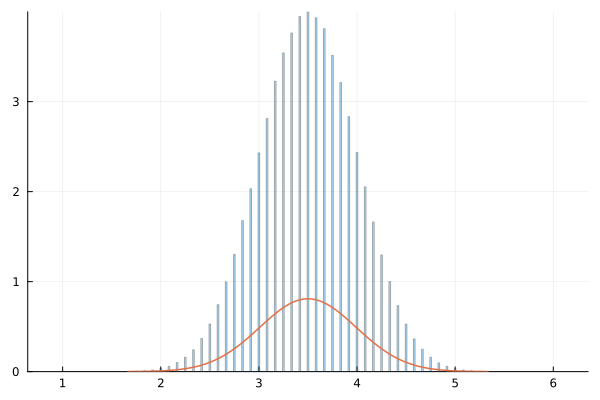

In [8]:
@show dist = DiscreteUniform(1, 6)
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=1-1/24:1/60:6+1/24, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = MixtureModel([Normal(), Normal(40)], [1 - 1 / 40, 1 / 40]) = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9750): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0250): Normal{Float64}(μ=40.0, σ=1.0)

n = 100 = 100
(μ, σ) = (mean(dist), std(dist)) = (1.0, 6.324555320336759)


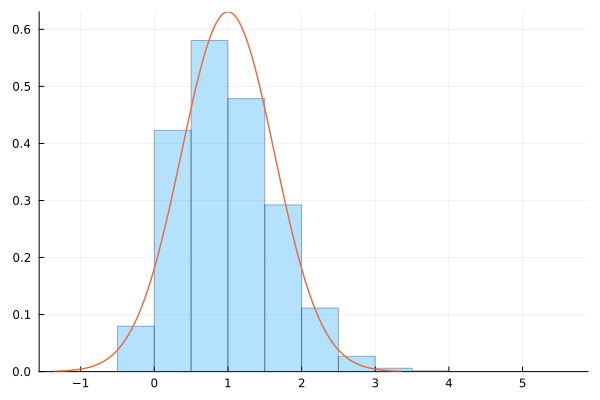

In [9]:
@show dist = MixtureModel([Normal(), Normal(40)], [1-1/40, 1/40])
@show n = 100
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=20, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = MixtureModel([Normal(), Normal(40)], [1 - 1 / 40, 1 / 40]) = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9750): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0250): Normal{Float64}(μ=40.0, σ=1.0)

n = 100 = 100
(μ, σ) = (mean(dist), std(dist)) = (1.0, 6.324555320336759)


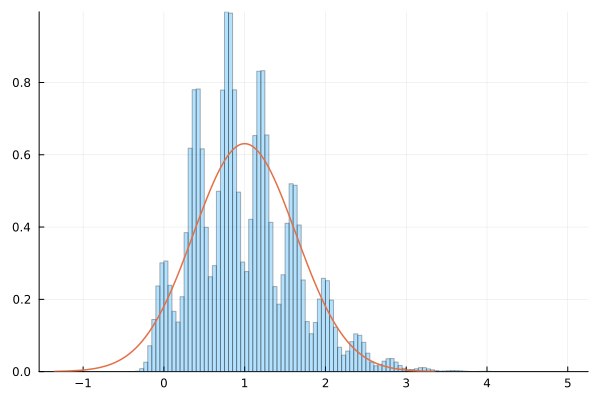

In [10]:
@show dist = MixtureModel([Normal(), Normal(40)], [1-1/40, 1/40])
@show n = 100
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
X̄ = f._ecdf.sorted_values
histogram(X̄; norm=true, alpha=0.3, bin=200, label="")
plot!(Normal(μ, σ/√n); label="", lw=1.5)

dist = Uniform() = Uniform{Float64}(a=0.0, b=1.0)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (0.5, 0.28867513459481287)


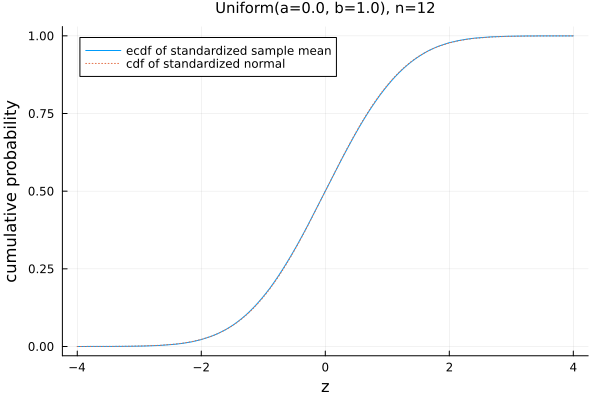

In [11]:
@show dist = Uniform()
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
plot(z -> f(μ + σ*z/√n), -4, 4; label="ecdf of standardized sample mean")
plot!(z -> cdf(Normal(), z), -4, 4; ls=:dot, label="cdf of standardized normal")
plot!(xguide="z", yguide="cumulative probability")
title!("$(distname(dist)), n=$n", titlefontsize=10)

dist = DiscreteUniform(1, 6) = DiscreteUniform(a=1, b=6)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (3.5, 1.707825127659933)


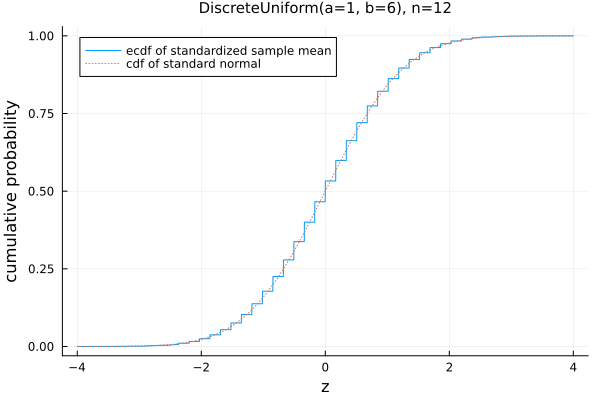

In [12]:
@show dist = DiscreteUniform(1, 6)
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
plot(z -> f(μ + σ*z/√n), -4, 4; label="ecdf of standardized sample mean")
plot!(z -> cdf(Normal(), z), -4, 4; ls=:dot, label="cdf of standard normal")
plot!(xguide="z", yguide="cumulative probability")
title!("$(distname(dist)), n=$n", titlefontsize=10)

dist = MixtureModel([Normal(), Normal(40)], [1 - 1 / 40, 1 / 40]) = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9750): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0250): Normal{Float64}(μ=40.0, σ=1.0)

n = 100 = 100
(μ, σ) = (mean(dist), std(dist)) = (1.0, 6.324555320336759)


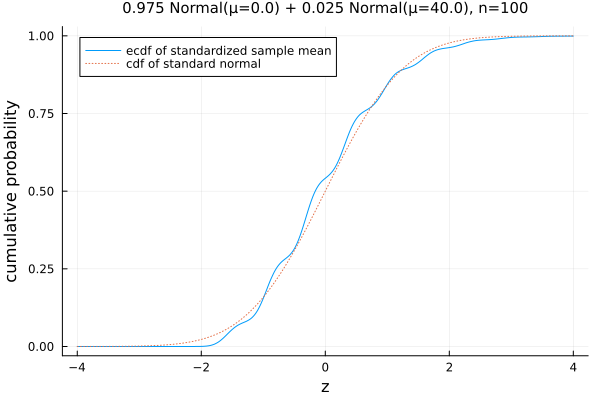

In [13]:
@show dist = MixtureModel([Normal(), Normal(40)], [1-1/40, 1/40])
@show n = 100
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
z = range(-4, 4, 1000)
plot(z, z -> f(μ + σ*z/√n); label="ecdf of standardized sample mean")
plot!(z, z -> cdf(Normal(), z); ls=:dot, label="cdf of standard normal")
plot!(xguide="z", yguide="cumulative probability")
title!("$(distname(dist)), n=$n", titlefontsize=10)

dist = Uniform() = Uniform{Float64}(a=0.0, b=1.0)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (0.5, 0.28867513459481287)


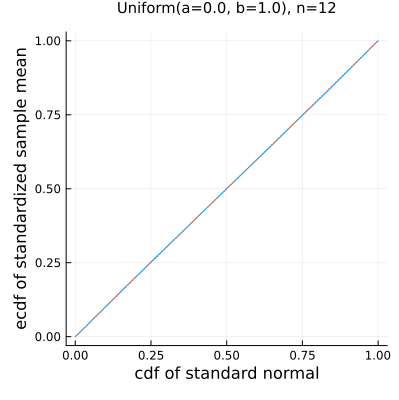

In [14]:
@show dist = Uniform()
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
z = range(-4, 4, 1000)
plot(cdf.(Normal(), z), @.(f(μ + σ*z/√n)); label="")
plot!(identity, 0, 1; label="", ls=:dot)
plot!(xguide="cdf of standard normal", yguide="ecdf of standardized sample mean")
title!("$(distname(dist)), n=$n", titlefontsize=10)
plot!(size=(400, 400))

dist = DiscreteUniform(1, 6) = DiscreteUniform(a=1, b=6)
n = 12 = 12
(μ, σ) = (mean(dist), std(dist)) = (3.5, 1.707825127659933)


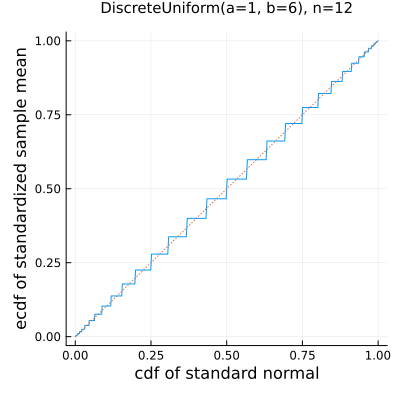

In [15]:
@show dist = DiscreteUniform(1, 6)
@show n = 12
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
z = range(-4, 4, 1000)
plot(cdf.(Normal(), z), @.(f(μ + σ*z/√n)); label="")
plot!(identity, 0, 1; label="", ls=:dot)
plot!(xguide="cdf of standard normal", yguide="ecdf of standardized sample mean")
title!("$(distname(dist)), n=$n", titlefontsize=10)
plot!(size=(400, 400))

dist = MixtureModel([Normal(), Normal(40)], [1 - 1 / 40, 1 / 40]) = MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.9750): Normal{Float64}(μ=0.0, σ=1.0)
components[2] (prior = 0.0250): Normal{Float64}(μ=40.0, σ=1.0)

n = 100 = 100
(μ, σ) = (mean(dist), std(dist)) = (1.0, 6.324555320336759)


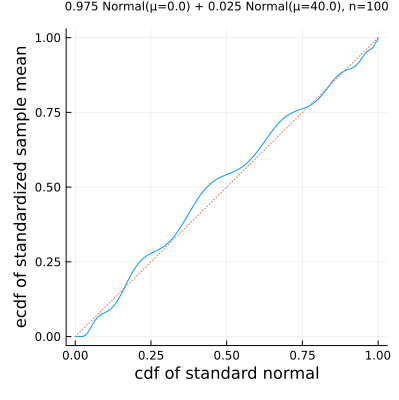

In [16]:
@show dist = MixtureModel([Normal(), Normal(40)], [1-1/40, 1/40])
@show n = 100
@show μ, σ = mean(dist), std(dist)
f = ecdf_samplemean(dist, n)
z = range(-4, 4, 1000)
plot(cdf.(Normal(), z), @.(f(μ + σ*z/√n)); label="")
plot!(identity, 0, 1; label="", ls=:dot)
plot!(xguide="cdf of standard normal", yguide="ecdf of standardized sample mean")
title!("$(distname(dist)), n=$n", titlefontsize=8)
plot!(size=(400, 400))

__二項検定の様々なP値__

In [17]:
x ⪅ y = x < y || x ≈ y

function pvalue_clopper_pearson(dist::DiscreteUnivariateDistribution, x)
    min(1, 2cdf(dist, x), 2ccdf(dist, x-1))
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    μ, σ = mean(dist), std(dist)
    kmin = max(minimum(dist), round(Int, μ - 6σ))
    kmax = min(maximum(dist), round(Int, μ + 6σ))
    sum(pdf(dist, k) for k in kmin:kmax if pdf(dist, k) ⪅ pdf(dist, x))
end

function pvalue_normal_approx(dist, x)
    μ, σ = mean(dist), std(dist)
    z = (x - μ) / σ
    2ccdf(Normal(), abs(z))
end

pvalue_normal_approx (generic function with 1 method)

In [18]:
n, p = 20, 1/3
x = 11
@show pvalue_clopper_pearson(Binomial(n, p), x)
@show pvalue_sterne(Binomial(n, p), x)
@show pvalue_normal_approx(Binomial(n, p), x)
;

pvalue_clopper_pearson(Binomial(n, p), x) = 0.0752731421893269
pvalue_sterne(Binomial(n, p), x) = 0.055229197407436634
pvalue_normal_approx(Binomial(n, p), x) = 0.039832619244741435


In [19]:
function sim(null, alt = null; L=10^6)
    pval_cp = Vector{Float64}(undef, L)
    pval_st = similar(pval_cp)
    pval_na = similar(pval_cp)
    Threads.@threads for i in 1:L
        x = rand(alt)
        pval_cp[i] = pvalue_clopper_pearson(null, x)
        pval_st[i] = pvalue_sterne(null, x)
        pval_na[i] = pvalue_normal_approx(null, x)
    end
    f_cp = make_ecdf(pval_cp)
    f_st = make_ecdf(pval_st)
    f_na = make_ecdf(pval_na)
    f_cp, f_st, f_na
end

sim (generic function with 2 methods)

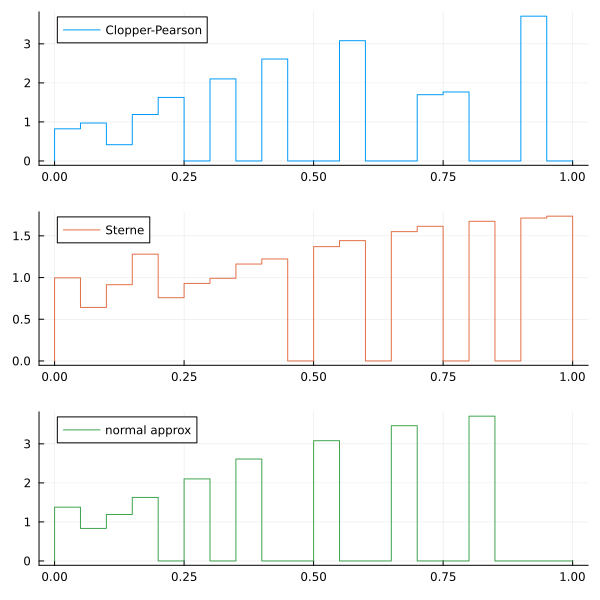

In [20]:
n, p = 100, 0.3
null = Binomial(n, p)
f_cp, f_st, f_na = sim(null)
pval_cp, pval_st, pval_na = (f._ecdf.sorted_values for f in (f_cp, f_st, f_na))

a, b, s = 0, 1, 0.1
bin = range(0, 1, 21)
P1 = stephist(pval_cp; norm=true, bin, label="Clopper-Pearson", c=1)
P2 = stephist(pval_st; norm=true, bin, label="Sterne", c=2)
P3 = stephist(pval_na; norm=true, bin, label="normal approx", c=3)
plot(P1, P2, P3; size=(600, 600), layout=(3, 1))
plot!(legend=:topleft)

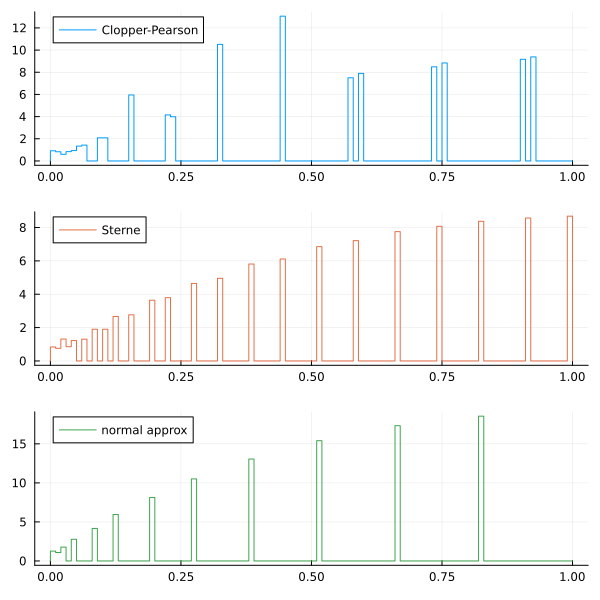

In [21]:
#n, p = 100, 0.3
#null = Binomial(n, p)
#f_cp, f_st, f_na = sim(null)
#pval_cp, pval_st, pval_na = (f._ecdf.sorted_values for f in (f_cp, f_st, f_na))

a, b, s = 0, 1, 0.1
bin = range(0, 1, 101)
P1 = stephist(pval_cp; norm=true, bin, label="Clopper-Pearson", c=1)
P2 = stephist(pval_st; norm=true, bin, label="Sterne", c=2)
P3 = stephist(pval_na; norm=true, bin, label="normal approx", c=3)
plot(P1, P2, P3; size=(600, 600), layout=(3, 1))
plot!(legend=:topleft)

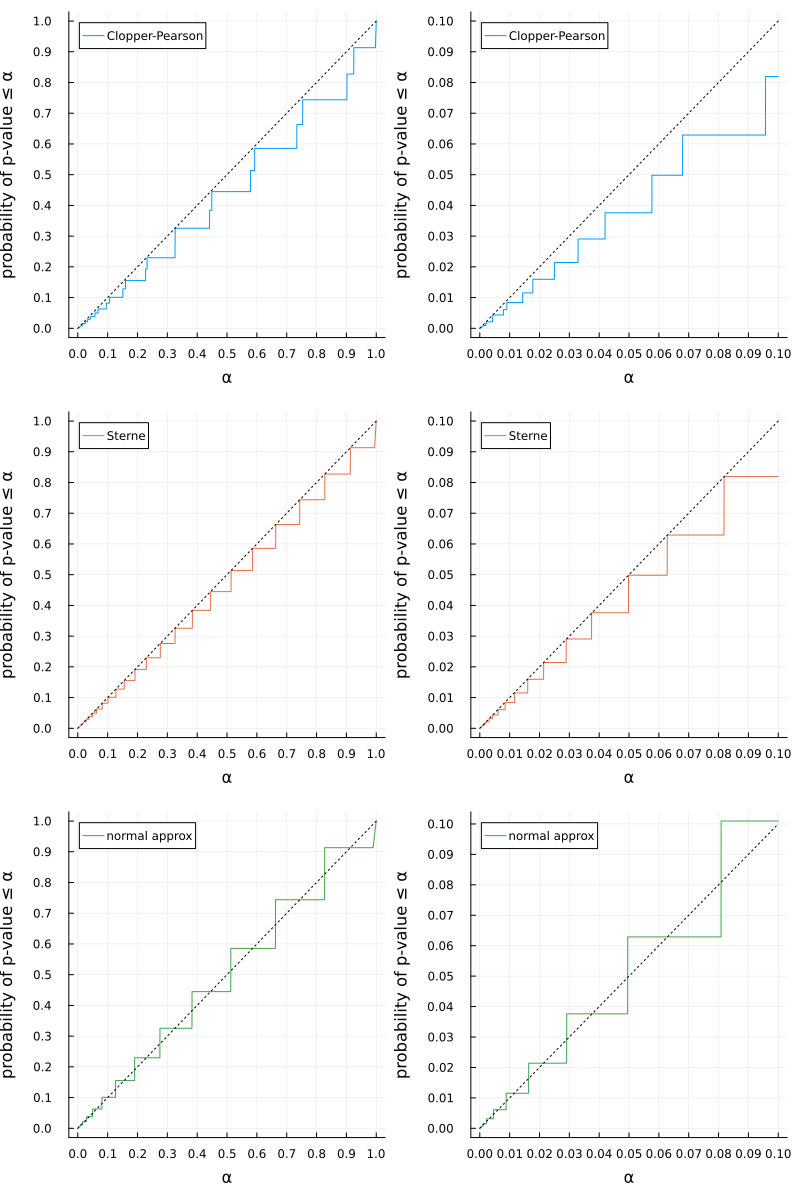

In [22]:
#n, p = 100, 0.3
#null = Binomial(n, p)
#f_cp, f_st, f_na = sim(null)

a, b, s = 0, 1, 0.1

P1 = plot(f_cp, a, b; label="Clopper-Pearson", c=1)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")

P2 = plot(f_st, a, b; label="Sterne", c=2)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")

P3 = plot(f_na, a, b; label="normal approx", c=3)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")
plot!(size=(400, 400))

a, b, s = 0, 0.1, 0.01

Q1 = plot(f_cp, a, b; label="Clopper-Pearson", c=1)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")

Q2 = plot(f_st, a, b; label="Sterne", c=2)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")

Q3 = plot(f_na, a, b; label="normal approx", c=3)
plot!(identity, a, b; label="", ls=:dot, c=:black)
plot!(xtick=a:s:b, ytick=a:s:b)
plot!(xguide="α", yguide="probability of p-value ≤ α")

plot(P1, Q1, P2, Q2, P3, Q3; size=(800, 1200), layout=(3, 2))
plot!(leftmargin=4Plots.mm)